# Project Model - Stephanie and Belu

Approach 1: Uses upper and lower molars from each species to train a model to predict the species class (Dinohippus interpolatus, Dinohippus mexicanus, and Equus simplicidens).  
Approach 2: Uses only upper or lower molars from from each of the species to train a model to predict the species class (Dinohippus interpolatus, Dinohippus mexicanus, and Equus simplicidens).

# Approach 1

In [10]:
# Import libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

os.environ['KERAS_BACKEND'] = 'torch'
from PIL import Image
from keras.preprocessing import image as image_utils
from keras.applications.densenet import preprocess_input, decode_predictions

import shutil
import keras
import pickle
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing import image as image_utils
from keras.applications.densenet import preprocess_input
from keras.applications.densenet import decode_predictions

from keras.layers import Dense

import copy

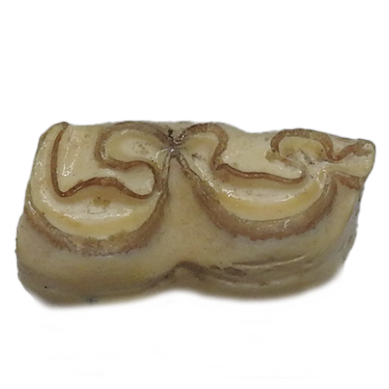

Image loaded successfully!


In [11]:
# Import file path and load an image to verify
file_path = "/lustre/fs0/bsc4892/skillingsworth/Project/Project/Images/Interpolatus_Lowers_Crop/1.png"

try:
    img = Image.open(file_path)  # Open the image with PIL
    plt.imshow(img)
    plt.axis("off")  # Hide axis
    plt.show()
    print("Image loaded successfully!")
except Exception as e:
    print("Error loading image:", e)

In [12]:
# Get current directory
current_directory = os.getcwd()
print(current_directory)

/lustre/fs0/bsc4892/skillingsworth/Project/Project


In [13]:
# Define paths
image_dir = "/lustre/fs0/bsc4892/skillingsworth/Project/Project/Images"

In [14]:
# List files within the defined path: image_dir
checkpoint_path = os.path.join(image_dir, ".ipynb_checkpoints")
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)

os.listdir(image_dir)

['Interpolatus_Lowers_Crop',
 'Simplicidens_Uppers_Crop',
 'Mexicanus_Lowers_Crop',
 'Simplicidens_Lowers_Crop',
 'Mexicanus_Uppers_Crop',
 'Interpolatus_Uppers_Crop']

In [16]:
# Function to show the images
def show_image(base_dir, max_images=10):
    """
    Iterates through all subfolders, finds images, and displays them.
    
    Args:
    - base_dir: The main directory containing subfolders with images.
    - max_images: Maximum number of images to display (default: 10).
    """
    image_count = 0  # Track how many images are shown

    for subfolder in sorted(os.listdir(base_dir)):  # Sort for consistency
        subfolder_path = os.path.join(base_dir, subfolder)

        if os.path.isdir(subfolder_path):  # Ensure it's a folder
            print(f"Opening images from category: {subfolder}")

            for image_file in sorted(os.listdir(subfolder_path)):  # Sort for consistency
                image_path = os.path.join(subfolder_path, image_file)

                if os.path.isfile(image_path):  # Check if it's a file
                    try:
                        img = Image.open(image_path)
                        plt.figure()
                        plt.imshow(img)
                        plt.axis("off")
                        plt.title(f"{subfolder}: {image_file}")
                        plt.show()

                        image_count += 1
                        if image_count >= max_images:  # Stop after max_images
                            return
                    except Exception as e:
                        print(f"Error loading {image_file}: {e}")

# Function to load and process the image
def load_and_process_image(image_path):
    try:
        img = Image.open(image_path)
        print("Original image shape:", np.array(img).shape)  # Print original shape
        
        # Load image and resize to 224x224
        img = image_utils.load_img(image_path, target_size=(224, 224))
        img_array = image_utils.img_to_array(img)  # Convert to NumPy array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)  # Preprocess for DenseNet

        print("Processed image shape:", img_array.shape)
        return img_array
    except Exception as e:
        print("Error processing image:", e)
        return None

# Function to make a prediction using DenseNet
def densenet_prediction(image_path, model):
    show_image(image_path)  # Display the image
    image = load_and_process_image(image_path)  # Process the image

    if image is not None:
        predictions = model.predict(image)  # Make a prediction
        print("Predicted:", decode_predictions(predictions, top=3))  # Decode results

Opening images from category: Interpolatus_Lowers_Crop


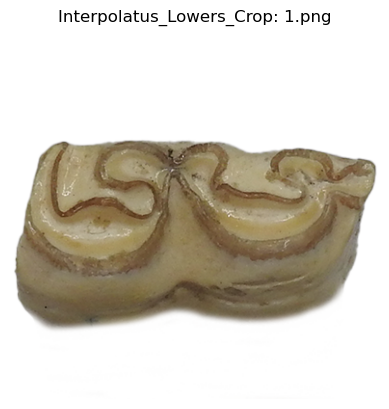

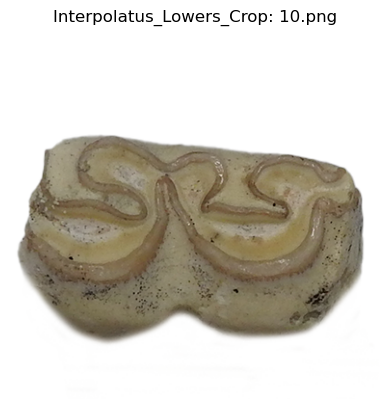

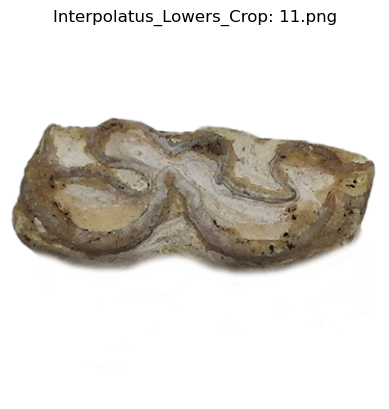

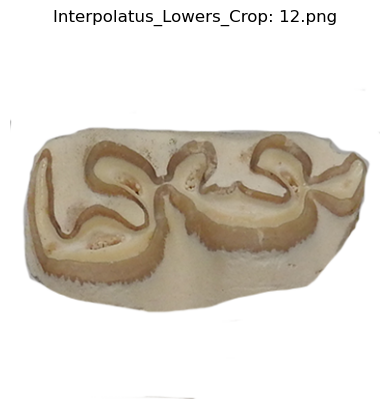

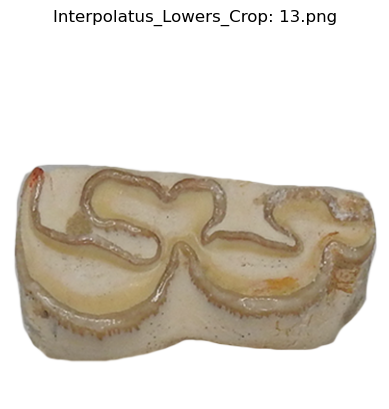

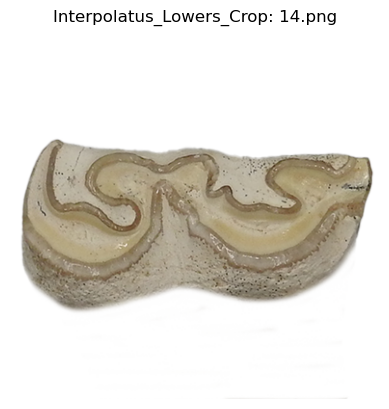

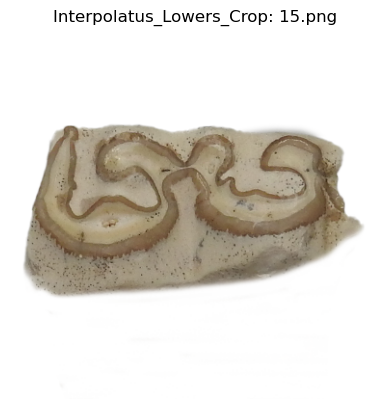

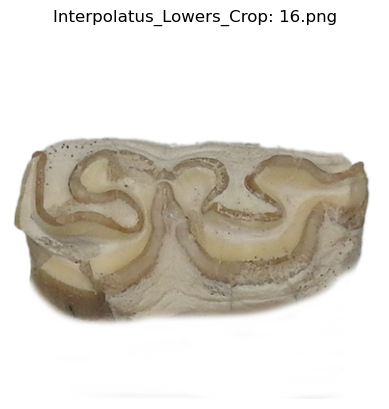

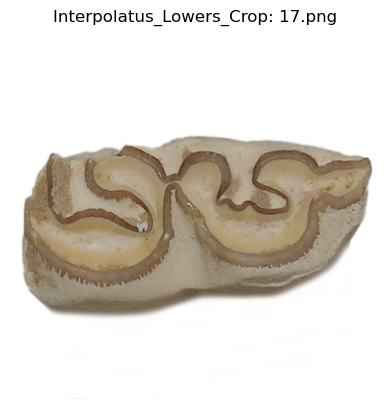

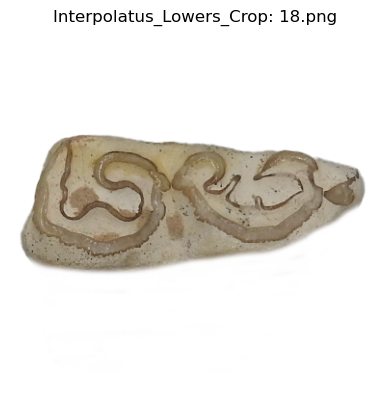

In [17]:
show_image(image_dir)

In [18]:
# Get a model ready version of the images to be used in classification and feature extraction, converting 384 X 384 and 3 color channels to 224 X 224 and 3 color channels.
load_and_process_image(file_path)

Original image shape: (384, 384, 3)
Processed image shape: (1, 224, 224, 3)


array([[[[2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         ...,
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ]],

        [[2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         ...,
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ]],

        [[2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         ...,
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ]],

        ...,

        [[2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         ...,


In [19]:
# Define transformations to normalize the data for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
# Relabeling 6 classes based on first 5 letters of folder names and grouping (i.e. upper and lower mexicanus into the same class) down to 3 classes.
import os 
from torchvision.datasets import ImageFolder 
from torch.utils.data import Subset, DataLoader 
import random 
import copy 

# Step 1: Load dataset and map folder names 
dataset = ImageFolder(root=image_dir) 

# Step 2: Build mapping: original class idx -> new class idx based on first 5 letters 
folder_to_new_class = {} 
new_class_name_to_idx = {} 
next_class_idx = 0  

for folder_name in dataset.classes: 
    key = folder_name[:5] 
    if key not in new_class_name_to_idx: 
        new_class_name_to_idx[key] = next_class_idx 
        next_class_idx += 1 
    folder_to_new_class[folder_name] = new_class_name_to_idx[key] 

# Step 3: Relabel targets 
remapped_targets = [folder_to_new_class[dataset.classes[target]] for target in dataset.targets]  

# Step 4: Group indices by new class labels 
unique_classes = set(remapped_targets) 
class_indices = {c: [] for c in unique_classes} 
for idx, target in enumerate(remapped_targets): 
    class_indices[target].append(idx)  

# Step 5: Stratified train/val split 
train_indices = [] 
val_indices = [] 

for class_label, indices in class_indices.items(): 
    n_samples = len(indices) 
    n_train = max(int(n_samples * 0.8), 1) 
    n_val = max(1, n_samples - n_train)  
    random.shuffle(indices) 
    train_indices.extend(indices[:n_train]) 
    val_indices.extend(indices[-n_val:]) 
random.shuffle(train_indices) 
random.shuffle(val_indices) 

# Step 6: Create datasets and loaders 
train_dataset = copy.deepcopy(dataset) 
train_dataset.targets = [remapped_targets[i] for i in train_indices] 
train_dataset = Subset(train_dataset, train_indices) 
train_dataset.dataset.transform = train_transform 

val_dataset = copy.deepcopy(dataset) 
val_dataset.targets = [remapped_targets[i] for i in val_indices] 
val_dataset = Subset(val_dataset, val_indices) 
val_dataset.dataset.transform = val_transform 

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=3) 
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=3) 

# Step 7: Sanity check 
train_classes = set([remapped_targets[i] for i in train_indices])
val_classes = set([remapped_targets[i] for i in val_indices])

print(f"Number of new classes: {len(unique_classes)}") 
print(f"Classes in training set: {train_classes}") 
print(f"Classes in validation set: {val_classes}") 
print(f"Training set size: {len(train_indices)}") 
print(f"Validation set size: {len(val_indices)}") 

Number of new classes: 3
Classes in training set: {0, 1, 2}
Classes in validation set: {0, 1, 2}
Training set size: 448
Validation set size: 114


In [21]:
# Print dataset sizes to check above regrouping code training and validation set sizes.
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 448
Validation set size: 114


In [22]:
# Load DenseNet121 model pre-trained on ImageNet
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

In [23]:
# Modify the classifier to match the number of categories (6)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 6)

In [24]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [25]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100. * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), "densenet121_horseteeth.pth") # Permissions issue to save here

Epoch 1/5, Loss: 1.0558, Accuracy: 58.93%
Validation Loss: 1.5428, Validation Accuracy: 61.40%
Epoch 2/5, Loss: 0.6864, Accuracy: 73.88%
Validation Loss: 1.0183, Validation Accuracy: 57.02%
Epoch 3/5, Loss: 0.5948, Accuracy: 75.89%
Validation Loss: 0.9576, Validation Accuracy: 67.54%
Epoch 4/5, Loss: 0.5406, Accuracy: 81.25%
Validation Loss: 0.5180, Validation Accuracy: 79.82%
Epoch 5/5, Loss: 0.4946, Accuracy: 80.58%
Validation Loss: 1.0979, Validation Accuracy: 56.14%


# Key Observations
Epoch 1: Baseline
Model starts with moderate accuracy ( around 59% train,  and 61% val).
Validation is better than training — could suggest slight underfitting or regularization.
Epoch 2: Overfitting Emerges
Training accuracy jumps (around 74%) but validation accuracy drops.
Training loss improves, but validation loss does not — classic early overfitting.
Epoch 3: Improvement
Both training and validation accuracy rise.
Indicates model is starting to generalize better.
Epoch 4: Peak Performance
Best training and validation performance: 81% and 79.8%.
Losses are low — excellent balance of fit and generalization.
Epoch 5: Overfitting Returns
Validation accuracy drops sharply to 56% even though training accuracy remains high.
Validation loss increases significantly — model may be memorizing.

# Interpretation of Overfitting
The model has likely:
Learned too much from the training data
Lost the ability to generalize to new (validation) data
This usually means:
The model is too complex for the size or variability of your dataset
You're training for too many epochs without regularization

# Potential Actions
1. Early Stopping: Automatically stop training once validation performance stops improving.
2. Add Regularization: Dropout layers (e.g., 0.5) in the classifier head. Weight decay (e.g., weight_decay=1e-4 in optimizer)
3. Data Augmentation: Helps simulate new data and prevent overfitting
4. Learning Rate Tuning: If learning rate is too high, the model may jump past optimal points. Try lr=1e-4 instead of the default 1e-3.
5. Cross-Validation: Split your dataset into more folds to better estimate generalization error.

# Conclusion
Your model showed strong potential — hitting over 80% train and ~80% validation accuracy by Epoch 4. However, the sharp drop in Epoch 5 confirms overfitting.

# Key takeaway: 
Your model architecture and features are sound, but it needs tighter control over training length and generalization.

# Computing ROC and Confusion Matrix
2. Fine-tuning added to the trained model with the addtion of an ROC curve and confusion matrix.

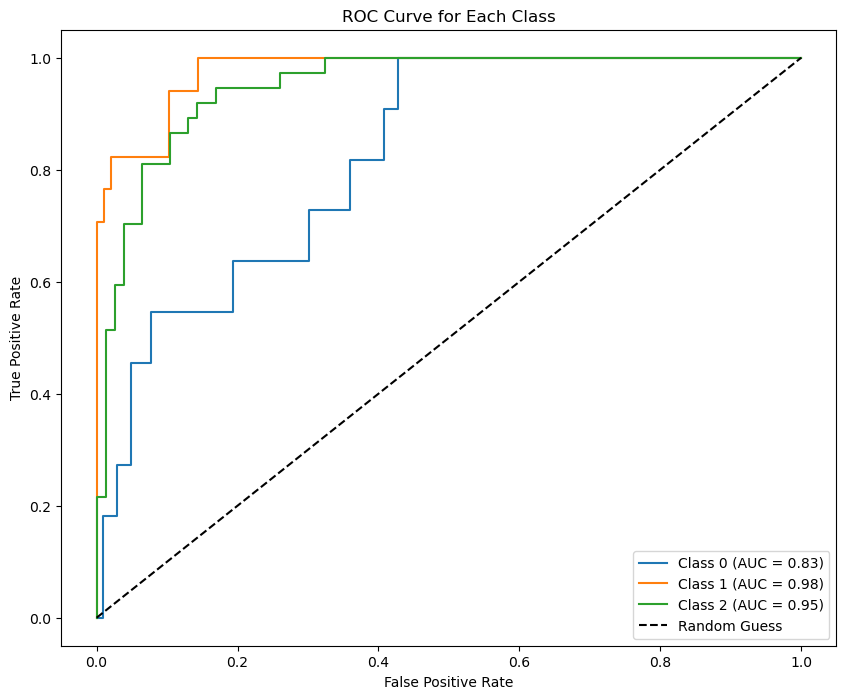

In [28]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store labels, predictions, and probabilities
all_labels = []
all_preds = []
all_probs = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in val_loader:
        # Move data to the appropriate device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        outputs = model(images)

        # Compute probabilities using softmax
        probs = torch.softmax(outputs, dim=1)

        # Get predicted class
        _, predicted = outputs.max(1)

        # Store labels, predictions, and probabilities
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Compute ROC Curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
num_classes = 3  # Adjust this based on the number of classes in your dataset
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

# AUC and Confusion Matrix Breakdown

1. Understanding AUC
AUC measures the ability of the model to correctly classify positive and negative instances across different thresholds.

A perfect model has an AUC of 1, meaning it perfectly distinguishes between all classes.

An AUC of 0.5 means the model performs no better than random guessing.

The closer the AUC is to 1, the better the model is at distinguishing between the classes.

2. Breakdown of Your AUCs (0.83, 0.98, 0.95)
These AUC values most likely correspond to different classes (e.g., if you have a multi-class problem, each AUC represents the performance for each class):

- AUC of 0.83:
This indicates that for one class, your model is reasonably good at distinguishing it from others but is not perfect.

Interpretation: This class is somewhat difficult for the model to distinguish. The model has an 83% chance of correctly ranking a randomly chosen positive instance higher than a randomly chosen negative instance.

Action: You could consider improving the model’s performance for this class using techniques like data augmentation or class weighting to give the model more focus on this class.

- AUC of 0.98:
A very high value, indicating that the model is excellent at distinguishing this class from others.

Interpretation: The model has a 98% chance of correctly ranking a positive instance for this class higher than a randomly chosen negative instance. This is a near-perfect performance.

Action: This class is well-understood by the model. No immediate action may be necessary here, but it’s good to check if the dataset for this class is large enough, as an overrepresented class can sometimes lead to bias.

- AUC of 0.95:
This is also a very good score, indicating that the model is performing well for another class.

Interpretation: The model has a 95% chance of distinguishing this class from others correctly. While not as strong as the 0.98 AUC, this is still a very solid result.

Action: This class is performing well. However, if you’re trying to optimize further, consider techniques to make it as robust as the class with 0.98 AUC.

3. Overall Model Performance
In general, these AUCs suggest that your model is doing quite well, especially for most of the classes. AUC of 0.83 indicates some room for improvement, especially for the harder-to-classify class.

If this is a multi-class classification, the average AUC across all classes can give you a more balanced view of overall performance.

4. What You Can Do Next:
Class Imbalance: If certain classes have much lower AUCs (like 0.83), it could indicate class imbalance, where the model struggles more with underrepresented classes. Techniques like SMOTE (Synthetic Minority Over-sampling Technique) or class weighting can help.

Model Tuning: Try adjusting the model architecture, increasing training epochs, or experimenting with different hyperparameters (e.g., learning rate, batch size) to improve the AUC for lower-performing classes.

Feature Engineering: Explore adding or modifying features that might help the model learn better decision boundaries for that particular class.

In [29]:
# Original class names from ImageFolder (i.e., your folder names)
class_names = dataset.classes

# Auto-group folders by their first 5 characters
folder_to_group = {}
group_names = {}
group_id = 0

for name in class_names:
    key = name[:5]
    if key not in group_names:
        
        group_names[key] = group_id
        group_id += 1
    folder_to_group[name] = group_names[key]

# Map original class indices to merged group indices
index_to_group = {i: folder_to_group[name] for i, name in enumerate(class_names)}

# Remap predictions and labels using merged group indices
all_preds_remapped = np.array([index_to_group[p] for p in all_preds])
all_labels_remapped = np.array([index_to_group[l] for l in all_labels])

# Optional: Get readable group labels for display
merged_class_labels = [f"{k}_*" for k in group_names.keys()]

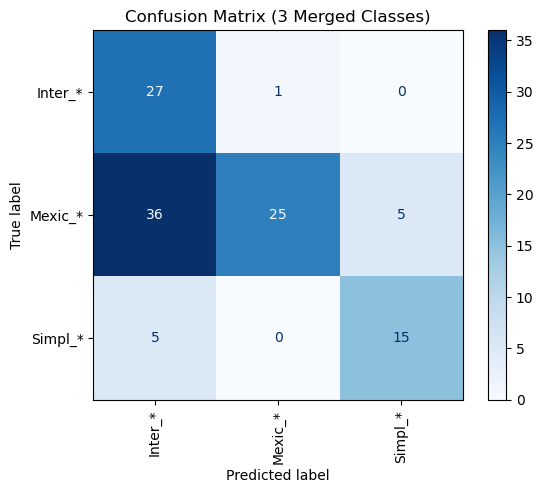

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels_remapped, all_preds_remapped)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=merged_class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix (3 Merged Classes)")
plt.show()

# Model Prediction and Saliency

Create a sequence of transformations that resize the image to 224x224 pixels as standard when using pretrained models. Converts to tensor with shape [C, H, W], values scaled from [0,255] to [0.0, 1.0]. This normalizes the color using the ImageNet mean and standard and centers all values around 0 to help the model generalize better.

In [31]:
# Load packages
from PIL import Image
from torchvision import transforms
import torch

# Load the image using PIL
file_path = "/lustre/fs0/bsc4892/skillingsworth/Project/Project/Images/Mexicanus_Uppers_Crop/130.png"
pil_image = Image.open(file_path).convert("RGB")  # Ensure 3-channel RGB image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by the model
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(           # Normalize with mean and std (example: ImageNet values)
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])


# Apply the transformations
image = transform(pil_image)  # This is now a tensor with shape [C, H, W]

# Add a batch dimension if needed by the model
image = image.unsqueeze(0)  # Shape becomes [1, C, H, W] (batch size = 1)

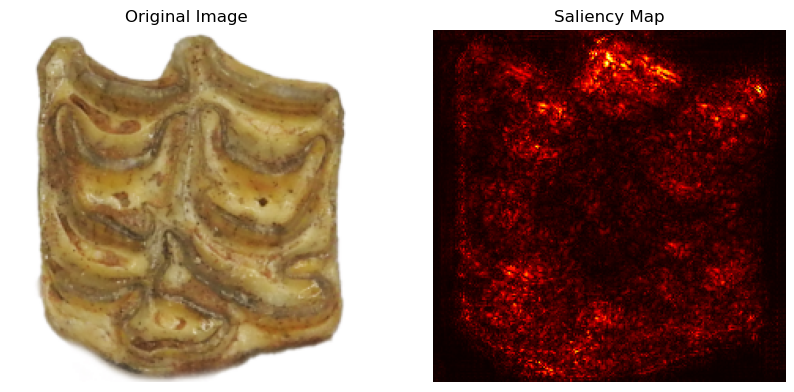

In [32]:
# --- Model Prediction + Saliency ---

import torchvision.transforms.functional as F

image = image.to("cuda").detach().clone()
image.requires_grad_()

model.eval()
model = model.to("cuda")

output = model(image)
predicted_class = output.argmax(dim=1).item()
output[0, predicted_class].backward()

# --- Saliency ---
saliency = image.grad.abs().squeeze()
if saliency.ndim == 3:
    saliency = saliency.max(dim=0)[0]

saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

# --- Unnormalize for Display ---
# --- Unnormalize Helper ---
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img_for_plot = unnormalize(image[0].detach().cpu().clone(), mean, std)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(F.to_pil_image(img_for_plot))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(saliency.cpu().numpy(), cmap='hot')
plt.title("Saliency Map")
plt.axis("off")
plt.show()


# Approach 2

In [39]:
import os

# Define your image directory
image_dir = "/lustre/fs0/bsc4892/skillingsworth/Project/Project/Images"

# Get only folders that contain "lower" in their name (case-insensitive)
lower_folders = [folder for folder in os.listdir(image_dir)
                 if os.path.isdir(os.path.join(image_dir, folder)) and "lower" in folder.lower()]

# Display the list of folders
print("Lower folders found:", lower_folders)


Lower folders found: ['Interpolatus_Lowers_Crop', 'Mexicanus_Lowers_Crop', 'Simplicidens_Lowers_Crop']


In [41]:
from PIL import Image
import numpy as np
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image as image_utils

# Function to load and process a single image
def load_and_process_image(image_path):
    try:
        # Load image and resize to 224x224
        img = image_utils.load_img(image_path, target_size=(224, 224))
        img_array = image_utils.img_to_array(img)  # Convert to NumPy array (224, 224, 3)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension -> (1, 224, 224, 3)
        img_array = preprocess_input(img_array)  # Preprocess for DenseNet
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}:", e)
        return None

# Collect and process all lower images
processed_images = []
image_labels = []

for folder in lower_folders:
    folder_path = os.path.join(image_dir, folder)
    label = folder.split('_')[0].lower()  # e.g., 'interpolatus'

    for file in os.listdir(folder_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, file)
            processed = load_and_process_image(image_path)
            if processed is not None:
                processed_images.append(processed)
                image_labels.append(label)

# Convert list to array if needed (optional, if batching)
# final_array = np.vstack(processed_images)  # shape: (num_images, 224, 224, 3)

print(f"Processed {len(processed_images)} images.")
print("Example shape:", processed_images[0].shape if processed_images else "No images")


Processed 277 images.
Example shape: (1, 224, 224, 3)


In [43]:
# Show arrays for first few images
for i in range(min(3, len(processed_images))):  # Show up to 3 arrays
    print(f"\nImage {i + 1} (label: {image_labels[i]}):")
    print(processed_images[i])


Image 1 (label: interpolatus):
[[[[2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   ...
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]]

  [[2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   ...
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]]

  [[2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   ...
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]]

  ...

  [[2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   ...
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]]

  [[2.2489083 2.4285715 2.64     ]
   [2.2489083 2.4285715 2.64     ]
   [2.2489083 2

In [44]:
# Define transformations to normalize the data for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [46]:
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

# 1. Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(image_labels)  # e.g., 'interpolatus' -> 0, 'mexicanus' -> 1

# 2. Stack images and convert to PyTorch tensors
X = np.vstack(processed_images)  # shape: (N, 224, 224, 3)
X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, 3, 224, 224)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# 3. Create dataset
full_dataset = TensorDataset(X_tensor, y_tensor)

# 4. Split into train and val (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 5. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

# 6. Sanity check
print(f"Encoded class labels: {list(label_encoder.classes_)}")
print(f"Total samples: {len(full_dataset)}")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# Show one batch
for images, labels in train_loader:
    print(f"\nImage batch shape: {images.shape}")  # (B, 3, 224, 224)
    print(f"Label batch shape: {labels.shape}")
    print(f"Labels in batch (encoded): {labels}")
    break

Encoded class labels: [np.str_('interpolatus'), np.str_('mexicanus'), np.str_('simplicidens')]
Total samples: 277
Train samples: 221
Val samples: 56

Image batch shape: torch.Size([10, 3, 224, 224])
Label batch shape: torch.Size([10])
Labels in batch (encoded): tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 1])


In [47]:
# Load DenseNet121 model pre-trained on ImageNet
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

In [48]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load DenseNet121 with pretrained weights
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Freeze feature extractor if needed
for param in model.features.parameters():
    param.requires_grad = False  # Optional: freeze all convolutional layers

# Modify the classifier to match your number of classes
num_classes = 3
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [51]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")

Epoch 1/10 - Loss: 18.4346, Accuracy: 71.04%
Epoch 2/10 - Loss: 14.6431, Accuracy: 72.40%
Epoch 3/10 - Loss: 14.0825, Accuracy: 76.02%
Epoch 4/10 - Loss: 14.3093, Accuracy: 80.54%
Epoch 5/10 - Loss: 11.1566, Accuracy: 81.45%
Epoch 6/10 - Loss: 11.2893, Accuracy: 76.02%
Epoch 7/10 - Loss: 11.6775, Accuracy: 80.09%
Epoch 8/10 - Loss: 9.3717, Accuracy: 84.16%
Epoch 9/10 - Loss: 9.0544, Accuracy: 86.43%
Epoch 10/10 - Loss: 8.0392, Accuracy: 87.33%


In [53]:
model.eval()
val_correct = 0
val_total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_acc = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_acc:.2f}%")

Validation Accuracy: 89.29%


In [54]:
import torch
import numpy as np

model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


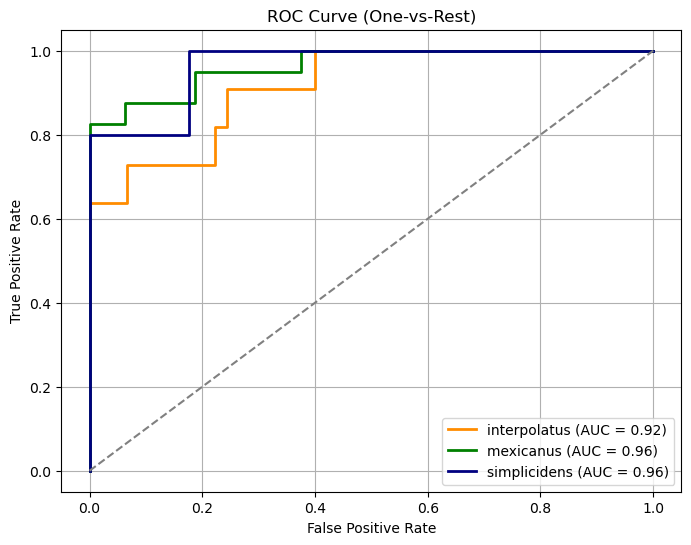

In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# One-hot encode true labels
n_classes = 3
y_true = label_binarize(all_labels, classes=[0, 1, 2])
y_score = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'navy']
class_names = ['interpolatus', 'mexicanus', 'simplicidens']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

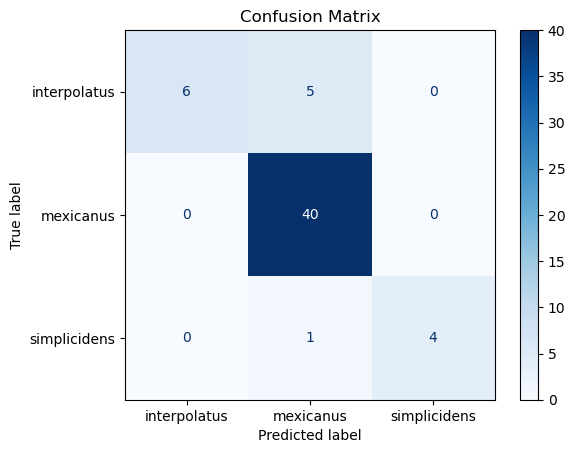

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['interpolatus', 'mexicanus', 'simplicidens'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [73]:
# Run a saliency map to visualize what the model is focusing on in an image.
# Get one sample from the validation set
image_tensor, label = val_dataset[5]  # or any index
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
image_tensor.requires_grad_()  # Enable gradient tracking

tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2

In [74]:
model.eval()
output = model(image_tensor)

# Get the predicted class score
score = output[0, label]
score.backward()  # Backprop on the score

In [75]:
model.eval()
output = model(image_tensor)

# Get the predicted class score
score = output[0, label]
score.backward()  # Backprop on the score

In [76]:
saliency = image_tensor.grad.abs().squeeze().detach().cpu().numpy()  # (3, 224, 224)
saliency = np.max(saliency, axis=0)  # Take max across channels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9306722..2.64].


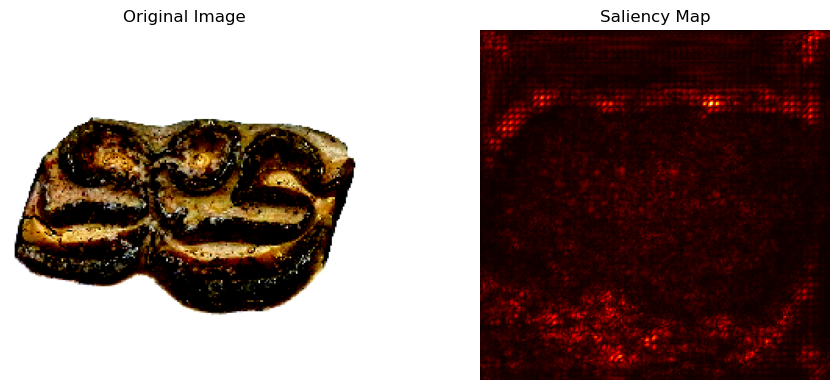

In [77]:
import matplotlib.pyplot as plt

# Original image
img_np = image_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency, cmap='hot')
plt.title("Saliency Map")
plt.axis('off')

plt.tight_layout()
plt.show()

# Discussion:
The model shows significant improvement over the 10 epochs, with both loss decreasing and accuracy increasing. The loss decreases consistently from 18.43 in Epoch 1 to 8.04 in Epoch 10, while the accuracy steadily improves from 71.04% to 87.33%. This indicates that the model is learning effectively and improving its ability to classify the data.

The accuracy increase, especially after Epochs 5-6, suggests that the model might be converging towards its optimal performance. However, there is a slight fluctuation in accuracy between Epoch 5 and Epoch 6 (from 81.45% to 76.02%), which could be due to minor overfitting or noisy data. After that, the accuracy steadily increases again.

Additionally, the model's AUC values (0.92, 0.96, and 0.96) are impressive, indicating that the model has strong discrimination ability and is successfully distinguishing between the classes, with little overlap between true positive and false positive rates.

# Conclusion:
The model is performing well, showing consistent improvements in accuracy and a decrease in loss. The AUC scores suggest the model has excellent performance in distinguishing the classes. The overall trend points towards a well-trained model, though further evaluation, such as on a validation set or with cross-validation, could provide additional insights into potential overfitting or generalization performance.